In [1]:
!pip install yfinance
import numpy as np
import pandas as pd
import warnings
import os
import yfinance as yf

     |████████████████████████████████| 6.4 MB 7.0 MB/s 
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [2]:
#1년

In [3]:
df = yf.download('012280.KS', start = '2019-01-01', end='2019-12-31')

[*********************100%***********************]  1 of 1 completed


In [4]:
df['CODE'] = 'SPY'

In [5]:
price_df = df.loc[:,['Adj Close']].copy()

In [6]:
price_df['center'] = price_df['Adj Close'].rolling(20).mean() # 20일 이동평균선

In [7]:
# +2 표준편차를 둔 상단 밴드
price_df['ub'] = price_df['center'] + 2 * price_df['Adj Close'].rolling(20).std() 

In [8]:
# -2 표준편차를 둔 하단 밴드
price_df['lb'] = price_df['center'] - 2 * price_df['Adj Close'].rolling(20).std()

In [9]:
n = 20 #이평선
sigma = 2 #시그마

In [10]:
def bollinger_band(price_df, n, sigma):
    bb = price_df.copy()
    bb['center'] = price_df['Adj Close'].rolling(n).mean() #중앙 이동평균선
    bb['ub'] = bb['center'] + sigma * price_df['Adj Close'].rolling(n).std() # 상단 밴드
    bb['lb'] = bb['center'] - sigma * price_df['Adj Close'].rolling(n).std() # 하단 밴드
    return bb

In [11]:
bollinger = bollinger_band(price_df, n, sigma)

In [12]:
base_date = '2009-01-02'

In [13]:
sample = bollinger.loc[base_date:]

In [14]:
book = sample[['Adj Close']].copy()

In [15]:
book['trade'] = '' #거래내역 컬럼

In [16]:
def create_trade_book(sample):
    book = sample[['Adj Close']].copy()
    book['trade'] = ''
    return (book)    

In [17]:
book = create_trade_book(sample)

In [18]:
def tradings(sample, book):
    for i in sample.index:
        if sample.loc[i, 'Adj Close'] > sample.loc[i, 'ub']: # 상단밴드 이탈시 동작 안함
            book.loc[i, 'trade'] = ''
        elif sample.loc[i, 'lb'] > sample.loc[i, 'Adj Close']: # 하반밴드 이탈시 매수
            if book.shift(1).loc[i, 'trade'] == 'buy':    # 이미 매수상태라면
                book.loc[i, 'trade'] = 'buy'     # 매수상태 유지
            else:
                book.loc[i, 'trade'] = 'buy'    
        elif sample.loc[i, 'ub'] >= sample.loc[i, 'Adj Close'] and sample.loc[i, 'Adj Close'] >= sample.loc[i, 'lb']: # 볼린저 밴드 안에 있을 시
            if book.shift(1).loc[i, 'trade'] == 'buy':
                book.loc[i, 'trade'] = 'buy'  # 매수상태 유지
            else:
                book.loc[i, 'trade'] = '' # 동작 안함
    return (book) 

In [19]:
book = tradings(sample,book)

In [20]:
for i in book.index:
    if book.loc[i, 'trade'] == 'buy' and book.shift(1).loc[i, 'trade'] == '':     # long 진입
        buy = book.loc[i, 'Adj Close']
        print('진입일 : ',i, 'long 진입가격 : ', buy)
    elif book.loc[i, 'trade'] == '' and book.shift(1).loc[i, 'trade'] == 'buy':     # long 청산
        sell = book.loc[i, 'Adj Close']
        rtn = (sell - buy) / buy + 1 # 손익 계산
        book.loc[i, 'return'] = rtn
        print('청산일 : ',i, 'long 진입가격 : ', buy, ' |  long 청산가격 : ', \
              sell, ' | return:', round(rtn, 4))

    if book.loc[i, 'trade'] == '':     # zero position
        buy = 0.0
        sell = 0.0

진입일 :  2019-05-09 00:00:00 long 진입가격 :  1389.90380859375
청산일 :  2019-06-10 00:00:00 long 진입가격 :  1389.90380859375  |  long 청산가격 :  1429.6153564453125  | return: 1.0286
진입일 :  2019-07-09 00:00:00 long 진입가격 :  1444.5072021484375
청산일 :  2019-11-08 00:00:00 long 진입가격 :  1444.5072021484375  |  long 청산가격 :  1419.6875  | return: 0.9828


In [21]:
def returns(book):
    # 손익 계산
    rtn = 1.0
    book['return'] = 1
    buy = 0.0
    sell = 0.0
    for i in book.index:
        if book.loc[i, 'trade'] == 'buy' and book.shift(1).loc[i, 'trade'] == '':     # long 진입
            buy = book.loc[i, 'Adj Close']
            print('진입일 : ',i, 'long 진입가격 : ', buy)
        elif book.loc[i, 'trade'] == '' and book.shift(1).loc[i, 'trade'] == 'buy':     # long 청산
            sell = book.loc[i, 'Adj Close']
            rtn = (sell - buy) / buy + 1 # 손익 계산
            book.loc[i, 'return'] = rtn
            print('청산일 : ',i, 'long 진입가격 : ', buy, ' |  long 청산가격 : ', \
                  sell, ' | return:', round(rtn, 4))
    
        if book.loc[i, 'trade'] == '':     # zero position
            buy = 0.0
            sell = 0.0
    
    acc_rtn = 1.0
    for i in book.index:
        rtn = book.loc[i, 'return']
        acc_rtn = acc_rtn * rtn  # 누적 수익률 계산
        book.loc[i, 'acc return'] = acc_rtn

    print ('Accunulated return :', round(acc_rtn, 4))
    return (round(acc_rtn, 4))

In [22]:
print(returns(book))

진입일 :  2019-05-09 00:00:00 long 진입가격 :  1389.90380859375
청산일 :  2019-06-10 00:00:00 long 진입가격 :  1389.90380859375  |  long 청산가격 :  1429.6153564453125  | return: 1.0286
진입일 :  2019-07-09 00:00:00 long 진입가격 :  1444.5072021484375
청산일 :  2019-11-08 00:00:00 long 진입가격 :  1444.5072021484375  |  long 청산가격 :  1419.6875  | return: 0.9828
Accunulated return : 1.0109
1.0109


In [23]:
import matplotlib.pylab as plt

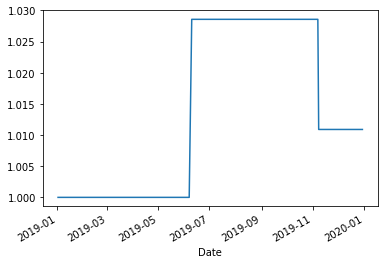

In [24]:
book['acc return'].plot()

In [25]:
#3년

In [26]:
df = yf.download('012280.KS', start = '2017-01-01', end='2019-12-31')

[*********************100%***********************]  1 of 1 completed


In [27]:
df['CODE'] = 'SPY'

In [28]:
price_df = df.loc[:,['Adj Close']].copy()

In [29]:
price_df['center'] = price_df['Adj Close'].rolling(20).mean() # 20일 이동평균선

In [30]:
# +2 표준편차를 둔 상단 밴드
price_df['ub'] = price_df['center'] + 2 * price_df['Adj Close'].rolling(20).std() 

In [31]:
# -2 표준편차를 둔 하단 밴드
price_df['lb'] = price_df['center'] - 2 * price_df['Adj Close'].rolling(20).std()

In [32]:
n = 20 #이평선
sigma = 2 #시그마

In [33]:
def bollinger_band(price_df, n, sigma):
    bb = price_df.copy()
    bb['center'] = price_df['Adj Close'].rolling(n).mean() #중앙 이동평균선
    bb['ub'] = bb['center'] + sigma * price_df['Adj Close'].rolling(n).std() # 상단 밴드
    bb['lb'] = bb['center'] - sigma * price_df['Adj Close'].rolling(n).std() # 하단 밴드
    return bb

In [34]:
bollinger = bollinger_band(price_df, n, sigma)

In [35]:
base_date = '2009-01-02'

In [36]:
sample = bollinger.loc[base_date:]

In [37]:
book = sample[['Adj Close']].copy()

In [38]:
book['trade'] = '' #거래내역 컬럼

In [39]:
def create_trade_book(sample):
    book = sample[['Adj Close']].copy()
    book['trade'] = ''
    return (book)    

In [40]:
book = create_trade_book(sample)

In [41]:
def tradings(sample, book):
    for i in sample.index:
        if sample.loc[i, 'Adj Close'] > sample.loc[i, 'ub']: # 상단밴드 이탈시 동작 안함
            book.loc[i, 'trade'] = ''
        elif sample.loc[i, 'lb'] > sample.loc[i, 'Adj Close']: # 하반밴드 이탈시 매수
            if book.shift(1).loc[i, 'trade'] == 'buy':    # 이미 매수상태라면
                book.loc[i, 'trade'] = 'buy'     # 매수상태 유지
            else:
                book.loc[i, 'trade'] = 'buy'    
        elif sample.loc[i, 'ub'] >= sample.loc[i, 'Adj Close'] and sample.loc[i, 'Adj Close'] >= sample.loc[i, 'lb']: # 볼린저 밴드 안에 있을 시
            if book.shift(1).loc[i, 'trade'] == 'buy':
                book.loc[i, 'trade'] = 'buy'  # 매수상태 유지
            else:
                book.loc[i, 'trade'] = '' # 동작 안함
    return (book) 

In [42]:
book = tradings(sample,book)

In [43]:
for i in book.index:
    if book.loc[i, 'trade'] == 'buy' and book.shift(1).loc[i, 'trade'] == '':     # long 진입
        buy = book.loc[i, 'Adj Close']
        print('진입일 : ',i, 'long 진입가격 : ', buy)
    elif book.loc[i, 'trade'] == '' and book.shift(1).loc[i, 'trade'] == 'buy':     # long 청산
        sell = book.loc[i, 'Adj Close']
        rtn = (sell - buy) / buy + 1 # 손익 계산
        book.loc[i, 'return'] = rtn
        print('청산일 : ',i, 'long 진입가격 : ', buy, ' |  long 청산가격 : ', \
              sell, ' | return:', round(rtn, 4))

    if book.loc[i, 'trade'] == '':     # zero position
        buy = 0.0
        sell = 0.0

진입일 :  2017-05-18 00:00:00 long 진입가격 :  1666.0164794921875
청산일 :  2018-01-25 00:00:00 long 진입가격 :  1666.0164794921875  |  long 청산가격 :  1538.822021484375  | return: 0.9237
진입일 :  2018-06-14 00:00:00 long 진입가격 :  1608.3172607421875
청산일 :  2018-09-11 00:00:00 long 진입가격 :  1608.3172607421875  |  long 청산가격 :  1568.605712890625  | return: 0.9753
진입일 :  2018-10-05 00:00:00 long 진입가격 :  1434.579345703125
청산일 :  2018-12-05 00:00:00 long 진입가격 :  1434.579345703125  |  long 청산가격 :  1300.5528564453125  | return: 0.9066
진입일 :  2019-05-09 00:00:00 long 진입가격 :  1389.90380859375
청산일 :  2019-06-10 00:00:00 long 진입가격 :  1389.90380859375  |  long 청산가격 :  1429.6153564453125  | return: 1.0286
진입일 :  2019-07-09 00:00:00 long 진입가격 :  1444.5072021484375
청산일 :  2019-11-08 00:00:00 long 진입가격 :  1444.5072021484375  |  long 청산가격 :  1419.6875  | return: 0.9828


In [44]:
def returns(book):
    # 손익 계산
    rtn = 1.0
    book['return'] = 1
    buy = 0.0
    sell = 0.0
    for i in book.index:
        if book.loc[i, 'trade'] == 'buy' and book.shift(1).loc[i, 'trade'] == '':     # long 진입
            buy = book.loc[i, 'Adj Close']
            print('진입일 : ',i, 'long 진입가격 : ', buy)
        elif book.loc[i, 'trade'] == '' and book.shift(1).loc[i, 'trade'] == 'buy':     # long 청산
            sell = book.loc[i, 'Adj Close']
            rtn = (sell - buy) / buy + 1 # 손익 계산
            book.loc[i, 'return'] = rtn
            print('청산일 : ',i, 'long 진입가격 : ', buy, ' |  long 청산가격 : ', \
                  sell, ' | return:', round(rtn, 4))
    
        if book.loc[i, 'trade'] == '':     # zero position
            buy = 0.0
            sell = 0.0
    
    acc_rtn = 1.0
    for i in book.index:
        rtn = book.loc[i, 'return']
        acc_rtn = acc_rtn * rtn  # 누적 수익률 계산
        book.loc[i, 'acc return'] = acc_rtn

    print ('Accunulated return :', round(acc_rtn, 4))
    return (round(acc_rtn, 4))

In [45]:
print(returns(book))

진입일 :  2017-05-18 00:00:00 long 진입가격 :  1666.0164794921875
청산일 :  2018-01-25 00:00:00 long 진입가격 :  1666.0164794921875  |  long 청산가격 :  1538.822021484375  | return: 0.9237
진입일 :  2018-06-14 00:00:00 long 진입가격 :  1608.3172607421875
청산일 :  2018-09-11 00:00:00 long 진입가격 :  1608.3172607421875  |  long 청산가격 :  1568.605712890625  | return: 0.9753
진입일 :  2018-10-05 00:00:00 long 진입가격 :  1434.579345703125
청산일 :  2018-12-05 00:00:00 long 진입가격 :  1434.579345703125  |  long 청산가격 :  1300.5528564453125  | return: 0.9066
진입일 :  2019-05-09 00:00:00 long 진입가격 :  1389.90380859375
청산일 :  2019-06-10 00:00:00 long 진입가격 :  1389.90380859375  |  long 청산가격 :  1429.6153564453125  | return: 1.0286
진입일 :  2019-07-09 00:00:00 long 진입가격 :  1444.5072021484375
청산일 :  2019-11-08 00:00:00 long 진입가격 :  1444.5072021484375  |  long 청산가격 :  1419.6875  | return: 0.9828
Accunulated return : 0.8256
0.8256


In [46]:
import matplotlib.pylab as plt

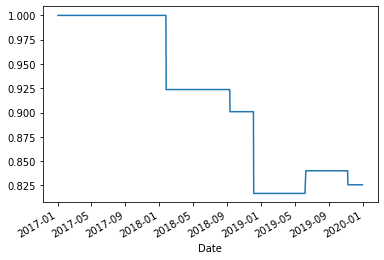

In [47]:
book['acc return'].plot()

In [48]:
#5년

In [49]:
df = yf.download('012280.KS', start = '2015-01-01', end='2019-12-31')

[*********************100%***********************]  1 of 1 completed


In [50]:
df['CODE'] = 'SPY'

In [51]:
price_df = df.loc[:,['Adj Close']].copy()

In [52]:
price_df['center'] = price_df['Adj Close'].rolling(20).mean() # 20일 이동평균선

In [53]:
# +2 표준편차를 둔 상단 밴드
price_df['ub'] = price_df['center'] + 2 * price_df['Adj Close'].rolling(20).std() 

In [54]:
# -2 표준편차를 둔 하단 밴드
price_df['lb'] = price_df['center'] - 2 * price_df['Adj Close'].rolling(20).std()

In [55]:
n = 20 #이평선
sigma = 2 #시그마

In [56]:
def bollinger_band(price_df, n, sigma):
    bb = price_df.copy()
    bb['center'] = price_df['Adj Close'].rolling(n).mean() #중앙 이동평균선
    bb['ub'] = bb['center'] + sigma * price_df['Adj Close'].rolling(n).std() # 상단 밴드
    bb['lb'] = bb['center'] - sigma * price_df['Adj Close'].rolling(n).std() # 하단 밴드
    return bb

In [57]:
bollinger = bollinger_band(price_df, n, sigma)

In [58]:
base_date = '2009-01-02'

In [59]:
sample = bollinger.loc[base_date:]

In [60]:
book = sample[['Adj Close']].copy()

In [61]:
book['trade'] = '' #거래내역 컬럼

In [62]:
def create_trade_book(sample):
    book = sample[['Adj Close']].copy()
    book['trade'] = ''
    return (book)    

In [63]:
book = create_trade_book(sample)

In [64]:
def tradings(sample, book):
    for i in sample.index:
        if sample.loc[i, 'Adj Close'] > sample.loc[i, 'ub']: # 상단밴드 이탈시 동작 안함
            book.loc[i, 'trade'] = ''
        elif sample.loc[i, 'lb'] > sample.loc[i, 'Adj Close']: # 하반밴드 이탈시 매수
            if book.shift(1).loc[i, 'trade'] == 'buy':    # 이미 매수상태라면
                book.loc[i, 'trade'] = 'buy'     # 매수상태 유지
            else:
                book.loc[i, 'trade'] = 'buy'    
        elif sample.loc[i, 'ub'] >= sample.loc[i, 'Adj Close'] and sample.loc[i, 'Adj Close'] >= sample.loc[i, 'lb']: # 볼린저 밴드 안에 있을 시
            if book.shift(1).loc[i, 'trade'] == 'buy':
                book.loc[i, 'trade'] = 'buy'  # 매수상태 유지
            else:
                book.loc[i, 'trade'] = '' # 동작 안함
    return (book) 

In [65]:
book = tradings(sample,book)

In [66]:
for i in book.index:
    if book.loc[i, 'trade'] == 'buy' and book.shift(1).loc[i, 'trade'] == '':     # long 진입
        buy = book.loc[i, 'Adj Close']
        print('진입일 : ',i, 'long 진입가격 : ', buy)
    elif book.loc[i, 'trade'] == '' and book.shift(1).loc[i, 'trade'] == 'buy':     # long 청산
        sell = book.loc[i, 'Adj Close']
        rtn = (sell - buy) / buy + 1 # 손익 계산
        book.loc[i, 'return'] = rtn
        print('청산일 : ',i, 'long 진입가격 : ', buy, ' |  long 청산가격 : ', \
              sell, ' | return:', round(rtn, 4))

    if book.loc[i, 'trade'] == '':     # zero position
        buy = 0.0
        sell = 0.0

진입일 :  2015-05-07 00:00:00 long 진입가격 :  1358.50634765625
청산일 :  2015-06-24 00:00:00 long 진입가격 :  1358.50634765625  |  long 청산가격 :  1455.8736572265625  | return: 1.0717
진입일 :  2015-08-12 00:00:00 long 진입가격 :  1418.24462890625
청산일 :  2015-12-02 00:00:00 long 진입가격 :  1418.24462890625  |  long 청산가격 :  1469.9024658203125  | return: 1.0364
진입일 :  2016-01-20 00:00:00 long 진입가격 :  1434.6239013671875
청산일 :  2016-03-28 00:00:00 long 진입가격 :  1434.6239013671875  |  long 청산가격 :  1745.4591064453125  | return: 1.2167
진입일 :  2016-08-08 00:00:00 long 진입가격 :  1879.3572998046875
청산일 :  2016-11-22 00:00:00 long 진입가격 :  1879.3572998046875  |  long 청산가격 :  1817.190185546875  | return: 0.9669
진입일 :  2017-01-24 00:00:00 long 진입가격 :  1797.1605224609375
청산일 :  2017-03-13 00:00:00 long 진입가격 :  1797.1605224609375  |  long 청산가격 :  2001.16259765625  | return: 1.1135
진입일 :  2017-05-18 00:00:00 long 진입가격 :  1666.0164794921875
청산일 :  2018-01-25 00:00:00 long 진입가격 :  1666.0164794921875  |  long 청산가격 :  1538.82202148437

In [67]:
def returns(book):
    # 손익 계산
    rtn = 1.0
    book['return'] = 1
    buy = 0.0
    sell = 0.0
    for i in book.index:
        if book.loc[i, 'trade'] == 'buy' and book.shift(1).loc[i, 'trade'] == '':     # long 진입
            buy = book.loc[i, 'Adj Close']
            print('진입일 : ',i, 'long 진입가격 : ', buy)
        elif book.loc[i, 'trade'] == '' and book.shift(1).loc[i, 'trade'] == 'buy':     # long 청산
            sell = book.loc[i, 'Adj Close']
            rtn = (sell - buy) / buy + 1 # 손익 계산
            book.loc[i, 'return'] = rtn
            print('청산일 : ',i, 'long 진입가격 : ', buy, ' |  long 청산가격 : ', \
                  sell, ' | return:', round(rtn, 4))
    
        if book.loc[i, 'trade'] == '':     # zero position
            buy = 0.0
            sell = 0.0
    
    acc_rtn = 1.0
    for i in book.index:
        rtn = book.loc[i, 'return']
        acc_rtn = acc_rtn * rtn  # 누적 수익률 계산
        book.loc[i, 'acc return'] = acc_rtn

    print ('Accunulated return :', round(acc_rtn, 4))
    return (round(acc_rtn, 4))

In [68]:
print(returns(book))

진입일 :  2015-05-07 00:00:00 long 진입가격 :  1358.50634765625
청산일 :  2015-06-24 00:00:00 long 진입가격 :  1358.50634765625  |  long 청산가격 :  1455.8736572265625  | return: 1.0717
진입일 :  2015-08-12 00:00:00 long 진입가격 :  1418.24462890625
청산일 :  2015-12-02 00:00:00 long 진입가격 :  1418.24462890625  |  long 청산가격 :  1469.9024658203125  | return: 1.0364
진입일 :  2016-01-20 00:00:00 long 진입가격 :  1434.6239013671875
청산일 :  2016-03-28 00:00:00 long 진입가격 :  1434.6239013671875  |  long 청산가격 :  1745.4591064453125  | return: 1.2167
진입일 :  2016-08-08 00:00:00 long 진입가격 :  1879.3572998046875
청산일 :  2016-11-22 00:00:00 long 진입가격 :  1879.3572998046875  |  long 청산가격 :  1817.190185546875  | return: 0.9669
진입일 :  2017-01-24 00:00:00 long 진입가격 :  1797.1605224609375
청산일 :  2017-03-13 00:00:00 long 진입가격 :  1797.1605224609375  |  long 청산가격 :  2001.16259765625  | return: 1.1135
진입일 :  2017-05-18 00:00:00 long 진입가격 :  1666.0164794921875
청산일 :  2018-01-25 00:00:00 long 진입가격 :  1666.0164794921875  |  long 청산가격 :  1538.82202148437

In [69]:
import matplotlib.pylab as plt

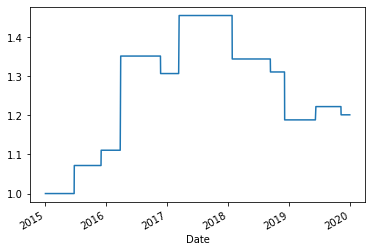

In [70]:
book['acc return'].plot()

In [71]:
#10년

In [72]:
df = yf.download('012280.KS', start = '2009-01-01', end='2019-12-31')

[*********************100%***********************]  1 of 1 completed


In [73]:
df['CODE'] = 'SPY'

In [74]:
price_df = df.loc[:,['Adj Close']].copy()

In [75]:
price_df['center'] = price_df['Adj Close'].rolling(20).mean() # 20일 이동평균선

In [76]:
# +2 표준편차를 둔 상단 밴드
price_df['ub'] = price_df['center'] + 2 * price_df['Adj Close'].rolling(20).std() 

In [77]:
# -2 표준편차를 둔 하단 밴드
price_df['lb'] = price_df['center'] - 2 * price_df['Adj Close'].rolling(20).std()

In [78]:
n = 20 #이평선
sigma = 2 #시그마

In [79]:
def bollinger_band(price_df, n, sigma):
    bb = price_df.copy()
    bb['center'] = price_df['Adj Close'].rolling(n).mean() #중앙 이동평균선
    bb['ub'] = bb['center'] + sigma * price_df['Adj Close'].rolling(n).std() # 상단 밴드
    bb['lb'] = bb['center'] - sigma * price_df['Adj Close'].rolling(n).std() # 하단 밴드
    return bb

In [80]:
bollinger = bollinger_band(price_df, n, sigma)

In [81]:
base_date = '2009-01-02'

In [82]:
sample = bollinger.loc[base_date:]

In [83]:
book = sample[['Adj Close']].copy()

In [84]:
book['trade'] = '' #거래내역 컬럼

In [85]:
def create_trade_book(sample):
    book = sample[['Adj Close']].copy()
    book['trade'] = ''
    return (book)    

In [86]:
book = create_trade_book(sample)

In [87]:
def tradings(sample, book):
    for i in sample.index:
        if sample.loc[i, 'Adj Close'] > sample.loc[i, 'ub']: # 상단밴드 이탈시 동작 안함
            book.loc[i, 'trade'] = ''
        elif sample.loc[i, 'lb'] > sample.loc[i, 'Adj Close']: # 하반밴드 이탈시 매수
            if book.shift(1).loc[i, 'trade'] == 'buy':    # 이미 매수상태라면
                book.loc[i, 'trade'] = 'buy'     # 매수상태 유지
            else:
                book.loc[i, 'trade'] = 'buy'    
        elif sample.loc[i, 'ub'] >= sample.loc[i, 'Adj Close'] and sample.loc[i, 'Adj Close'] >= sample.loc[i, 'lb']: # 볼린저 밴드 안에 있을 시
            if book.shift(1).loc[i, 'trade'] == 'buy':
                book.loc[i, 'trade'] = 'buy'  # 매수상태 유지
            else:
                book.loc[i, 'trade'] = '' # 동작 안함
    return (book) 

In [88]:
book = tradings(sample,book)

In [89]:
for i in book.index:
    if book.loc[i, 'trade'] == 'buy' and book.shift(1).loc[i, 'trade'] == '':     # long 진입
        buy = book.loc[i, 'Adj Close']
        print('진입일 : ',i, 'long 진입가격 : ', buy)
    elif book.loc[i, 'trade'] == '' and book.shift(1).loc[i, 'trade'] == 'buy':     # long 청산
        sell = book.loc[i, 'Adj Close']
        rtn = (sell - buy) / buy + 1 # 손익 계산
        book.loc[i, 'return'] = rtn
        print('청산일 : ',i, 'long 진입가격 : ', buy, ' |  long 청산가격 : ', \
              sell, ' | return:', round(rtn, 4))

    if book.loc[i, 'trade'] == '':     # zero position
        buy = 0.0
        sell = 0.0

진입일 :  2009-05-26 00:00:00 long 진입가격 :  458.26043701171875
청산일 :  2009-07-23 00:00:00 long 진입가격 :  458.26043701171875  |  long 청산가격 :  422.3965759277344  | return: 0.9217
진입일 :  2009-08-25 00:00:00 long 진입가격 :  378.56292724609375
청산일 :  2009-09-15 00:00:00 long 진입가격 :  378.56292724609375  |  long 청산가격 :  414.4267883300781  | return: 1.0947
진입일 :  2009-11-27 00:00:00 long 진입가격 :  382.5478515625
청산일 :  2009-12-16 00:00:00 long 진입가격 :  382.5478515625  |  long 청산가격 :  422.3965759277344  | return: 1.1042
진입일 :  2010-01-25 00:00:00 long 진입가격 :  390.5175476074219
청산일 :  2010-03-18 00:00:00 long 진입가격 :  390.5175476074219  |  long 청산가격 :  410.4419250488281  | return: 1.051
진입일 :  2010-10-07 00:00:00 long 진입가격 :  470.2150573730469
청산일 :  2010-10-14 00:00:00 long 진입가격 :  470.2150573730469  |  long 청산가격 :  524.4093627929688  | return: 1.1153
진입일 :  2010-12-13 00:00:00 long 진입가격 :  467.0271911621094
청산일 :  2011-01-13 00:00:00 long 진입가격 :  467.0271911621094  |  long 청산가격 :  510.9183044433594  | retu

In [90]:
def returns(book):
    # 손익 계산
    rtn = 1.0
    book['return'] = 1
    buy = 0.0
    sell = 0.0
    for i in book.index:
        if book.loc[i, 'trade'] == 'buy' and book.shift(1).loc[i, 'trade'] == '':     # long 진입
            buy = book.loc[i, 'Adj Close']
            print('진입일 : ',i, 'long 진입가격 : ', buy)
        elif book.loc[i, 'trade'] == '' and book.shift(1).loc[i, 'trade'] == 'buy':     # long 청산
            sell = book.loc[i, 'Adj Close']
            rtn = (sell - buy) / buy + 1 # 손익 계산
            book.loc[i, 'return'] = rtn
            print('청산일 : ',i, 'long 진입가격 : ', buy, ' |  long 청산가격 : ', \
                  sell, ' | return:', round(rtn, 4))
    
        if book.loc[i, 'trade'] == '':     # zero position
            buy = 0.0
            sell = 0.0
    
    acc_rtn = 1.0
    for i in book.index:
        rtn = book.loc[i, 'return']
        acc_rtn = acc_rtn * rtn  # 누적 수익률 계산
        book.loc[i, 'acc return'] = acc_rtn

    print ('Accunulated return :', round(acc_rtn, 4))
    return (round(acc_rtn, 4))

In [91]:
print(returns(book))

진입일 :  2009-05-26 00:00:00 long 진입가격 :  458.26043701171875
청산일 :  2009-07-23 00:00:00 long 진입가격 :  458.26043701171875  |  long 청산가격 :  422.3965759277344  | return: 0.9217
진입일 :  2009-08-25 00:00:00 long 진입가격 :  378.56292724609375
청산일 :  2009-09-15 00:00:00 long 진입가격 :  378.56292724609375  |  long 청산가격 :  414.4267883300781  | return: 1.0947
진입일 :  2009-11-27 00:00:00 long 진입가격 :  382.5478515625
청산일 :  2009-12-16 00:00:00 long 진입가격 :  382.5478515625  |  long 청산가격 :  422.3965759277344  | return: 1.1042
진입일 :  2010-01-25 00:00:00 long 진입가격 :  390.5175476074219
청산일 :  2010-03-18 00:00:00 long 진입가격 :  390.5175476074219  |  long 청산가격 :  410.4419250488281  | return: 1.051
진입일 :  2010-10-07 00:00:00 long 진입가격 :  470.2150573730469
청산일 :  2010-10-14 00:00:00 long 진입가격 :  470.2150573730469  |  long 청산가격 :  524.4093627929688  | return: 1.1153
진입일 :  2010-12-13 00:00:00 long 진입가격 :  467.0271911621094
청산일 :  2011-01-13 00:00:00 long 진입가격 :  467.0271911621094  |  long 청산가격 :  510.9183044433594  | retu

In [92]:
import matplotlib.pylab as plt

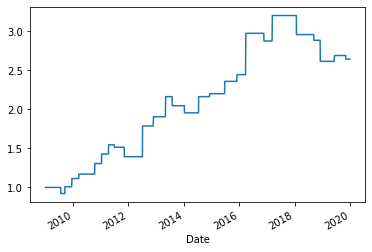

In [93]:
book['acc return'].plot()